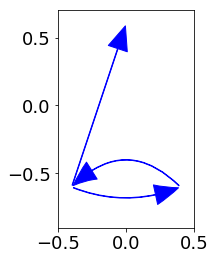

In [58]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

size_scale = 1
tw=0.5*size_scale
hw=20
hl=24

plt.figure()

plt.axes().set_xlim(-.5,0.5)
plt.axes().set_ylim(-0.9,0.7)
plt.axes().set_aspect(1)

style=f"Simple,tail_width={tw},head_width={hw},head_length={hl}"
kw = dict(arrowstyle=style, color="b")

a1 = patches.FancyArrowPatch((-0.4,-0.6), (0,0.6),**kw )
a2 = patches.FancyArrowPatch((0.4,-0.6), (-0.4,-0.6), connectionstyle="arc3,rad=.5", **kw)
a3 = patches.FancyArrowPatch((-0.4,-0.6), (0.4,-0.6),connectionstyle="arc3,rad=.2", **kw)

for a in [a1,a2,a3]:
    plt.gca().add_patch(a)
plt.show()

In [23]:
def draw_my_arrow(init_pos, end_pos):

    size_scale = 1
    tw=0.5*size_scale
    hw=20
    hl=24

    style=f"Simple,tail_width={tw},head_width={hw},head_length={hl}"
    kw = dict(arrowstyle=style, color="b")

    a = patches.FancyArrowPatch(init_pos, end_pos, connectionstyle="arc3,rad=.5", **kw)
    plt.gca().add_patch(a)

In [18]:
import numpy as np
import deepdish as dd
import matplotlib.pyplot as plt
import socket
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize
from scipy.ndimage.morphology import binary_erosion, binary_dilation
import os
from leap_utils.preprocessing import export_boxes
from videoreader import VideoReader
from leap_utils.plot import boxpos
from leap_utils.utils import unflatten
import matplotlib.ticker as ticker
plt.rcParams['font.size'] = 16

fname = 'mv_X200'
if socket.gethostname() == 'asus-lap':
    dat_folder = "C:/Users/Adrian/Documents/ServerFiles/dat"
    res_folder = "C:/Users/Adrian/Documents/ServerFiles/cluster_inspection"
    log_folder = "C:/Users/Adrian/Documents/ServerFiles/log"
    chmic_dat_folder = "C:/Users/Adrian/Documents/ServerFiles/dat"
    chmic_res_folder = "C:/Users/Adrian/Documents/ServerFiles/dat"
elif socket.gethostname() == 'UKME04-CW03':
    dat_folder = "../dat"
    res_folder = "../res"
    log_folder = "../log"
    chmic_dat_folder = "Z:/#Common/chainingmic/dat"
    chmic_res_folder = "Z:/#Common/chainingmic/res"
else:
    dat_folder = "/scratch/apalaci10/sandbox/dat"
    res_folder = "/scratch/apalaci10/cluster_inspection"
    log_folder = "/usr/users/apalaci/tsne_mv"
    chmic_dat_folder = "/scratch/clemens10/chainingmic/dat"
    chmic_res_folder = "/scratch/clemens10/chainingmic/res"

tsne_path = f"{dat_folder}/{fname}_tsne.h5"
all_labels_path = f"{dat_folder}/{fname}_all_labels.h5"
trans_path = f"{dat_folder}/{fname}_trans.h5"
all_poses_path = f"{dat_folder}/all_poses.h5"
indexing_path = f"{dat_folder}/mv_indexing.h5"
log_path = f"{log_folder}/{fname}_gifs.log"


In [20]:
def make_map(all_labels_path, icluster, *, nit = 1):
    labels = dd.io.load(all_labels_path, group='/ws_labels')
    image = dd.io.load(all_labels_path, group='/tsne_KDE')
    ulabels = np.unique(labels)

    labels_colors = np.zeros((ulabels.size, 4))
    labels_colors[ulabels == icluster, ...] = np.array([1,0,0,1])

    image_mask = image/np.amax(image) > 0.25
    new_image_mask = binary_dilation(image_mask, iterations = nit).astype(labels.dtype)
    ring = new_image_mask != image_mask

    other_labels = np.copy(labels)
    for ilabel in np.unique(other_labels):
        mask = other_labels == ilabel
        new_mask = binary_erosion(mask, iterations = nit).astype(labels.dtype)
        other_labels = np.where(mask, new_mask*ilabel, other_labels)

    new_labels = np.zeros((*image.shape,4))
    for ii in range(labels.shape[0]):
        for jj in range(labels.shape[1]):
            new_labels[ii,jj,:] = np.asarray(labels_colors[labels[ii,jj]-1])
            if other_labels[ii,jj] == 0:
                new_labels[ii,jj,:] = np.array([0,0,0,1])
            if ring[ii,jj] == 1:
                new_labels[ii,jj,:] = np.array([0,0,0,1])
            if new_image_mask[ii,jj] == 0:
                new_labels[ii,jj,:] = np.array([0,0,0,0])
    
    return new_labels, new_image_mask

In [67]:
def general_trans_map(pthr = 0.05):
    line_scale = 20
    nit = 1
    
    image = dd.io.load(all_labels_path, group='/tsne_KDE')
    labels = dd.io.load(all_labels_path, group='/ws_labels')
    ulabels = np.unique(labels)
    
    trans_mat = dd.io.load(trans_path, group='/or_trans_matrices')[0, ...]
    for ii in range(trans_mat.shape[0]):
        trans_mat[ii,:] = trans_mat[ii,:]/np.sum(trans_mat[ii,:])

    image_mask = image/np.amax(image) > 0.25
    new_image_mask = binary_dilation(image_mask, iterations = nit).astype(labels.dtype)
    ring = new_image_mask != image_mask

    other_labels = np.copy(labels)
    for ilabel in np.unique(labels):
        mask = labels == ilabel
        new_mask = binary_erosion(mask, iterations = nit).astype(labels.dtype)
        other_labels = np.where(mask, new_mask*ilabel, other_labels)

    cluster_center = np.zeros((ulabels.size,2))
    for ii in range(ulabels.size):
        cluster_center[ii,:] = np.mean(np.asarray(np.where(new_image_mask*labels==ulabels[ii])),axis=1).T

    for indx_iilabel in range(ulabels.size):        
        for indx_jjlabel in range(ulabels.size):
            if indx_jjlabel != indx_iilabel:
                if trans_mat[indx_iilabel,indx_jjlabel] > pthr:
#                     plt.plot([cluster_center[indx_jjlabel, 1], cluster_center[indx_iilabel, 1]], [cluster_center[indx_jjlabel, 0], cluster_center[indx_iilabel, 0]], color='b', linewidth=line_scale*(trans_mat[indx_iilabel,indx_jjlabel]-pthr)/(1-pthr))
#                     draw_my_arrow((cluster_center[indx_iilabel, 1], cluster_center[indx_iilabel, 0]), (cluster_center[indx_jjlabel, 1], cluster_center[indx_jjlabel, 0]), size_scale=line_scale*(trans_mat[indx_iilabel,indx_jjlabel]-pthr)/(1-pthr))
                    draw_my_arrow((cluster_center[indx_iilabel, 1], cluster_center[indx_iilabel, 0]), (cluster_center[indx_jjlabel, 1], cluster_center[indx_jjlabel, 0]), size_scale=line_scale*trans_mat[indx_iilabel,indx_jjlabel])

    plt.scatter(cluster_center[:, 1], cluster_center[:, 0], color='r', s=200)
    empty_labels, empty_image_mask = make_map(all_labels_path, 50)
    plt.imshow(empty_labels, interpolation='nearest')
    plt.gca().set_aspect('equal')
    plt.axis('off')

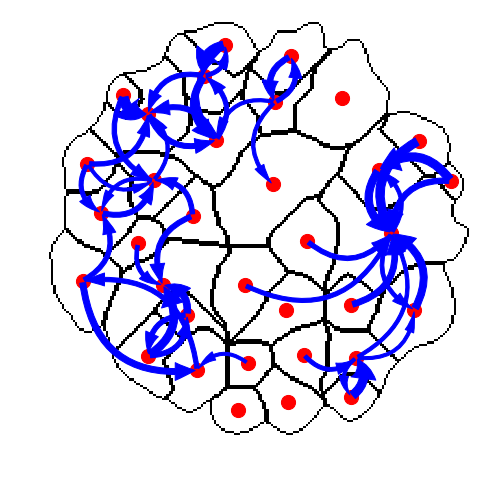

In [70]:
def draw_my_arrow(init_pos, end_pos, size_scale = 1):
    tw=0.5*size_scale*2
    hw=3*tw
    hl=20

    style=f"Simple,tail_width={tw},head_width={hw},head_length={hl}"
    kw = dict(arrowstyle=style, color="b")

    a = patches.FancyArrowPatch(init_pos, end_pos, connectionstyle="arc3,rad=.5", **kw)
    plt.gca().add_patch(a)
    
plt.rcParams['font.size'] = 18
save_figs = True
png_path = f"../fig/Transitions/"

plt.figure(figsize=[8,8])
general_trans_map(pthr = 0.15)
if save_figs:
    plt.savefig(png_path + f'all_transmap_pthr015.png',bbox_inches='tight')
    plt.savefig(png_path + f'all_transmap_pthr015.svg',bbox_inches='tight')
plt.show()


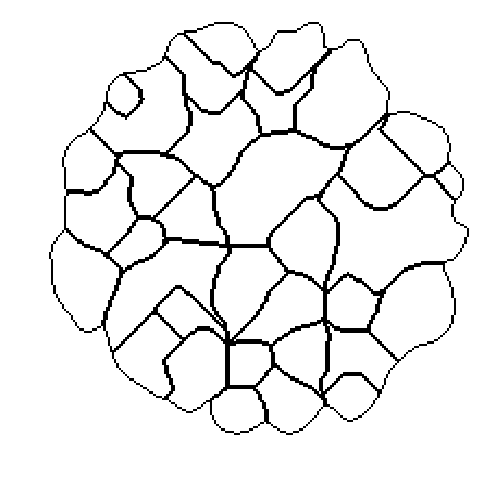

In [72]:
empty_labels, empty_image_mask = make_map(all_labels_path, 50)
plt.figure(figsize=[8,8])
plt.imshow(empty_labels, interpolation='nearest', aspect='equal')
plt.axis('off')
plt.savefig(f'../fig/{fname}_empty.png')
plt.savefig(f'../fig/{fname}_empty.svg')